In [1]:
#libraries to be used 

import numpy as np
import pandas as pd
import os

# for Preprocessing and word to vector feature vector
import nltk
from nltk.corpus import stopwords   
from gensim.models import Word2Vec, word2vec


#Import svm model
from sklearn import svm

#import matric to calculate
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve , f1_score
from sklearn.pipeline import Pipeline

#for parsing
import re
import string

# for graphs
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
#import data
df = pd.read_csv("dataset/SQLIA_Dataset.csv" )

In [3]:
# # balance dataset
# df =dataframe.iloc[:22912]

In [4]:
# count for each class in dataset
df['Label'].value_counts()

1    11456
0    11456
Name: Label, dtype: int64

In [5]:
#null values
df.isnull().sum()

Sentence    4
Label       0
dtype: int64

In [6]:
#drop null values
df.dropna(inplace= True)
df.reset_index(drop=True)

# count for each class in dataset
df.isnull().sum()

Sentence    0
Label       0
dtype: int64

array([[<AxesSubplot:title={'center':'Label'}>]], dtype=object)

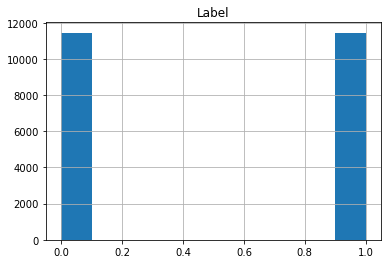

In [7]:
#histogram for value count of each class
df.hist("Label")

In [8]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')   # load tokenizer

In [9]:
# split test and train data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["Sentence"], df["Label"],
                                                        stratify= df["Label"], 
                                                    test_size=0.25)

In [10]:
#check the split for train
n_one_train = sum(y_train == 1)
print(f'Training set contains {n_one_train/len(y_train)} Positive values')

Training set contains 0.499970898085094 Positive values


In [11]:
#check the split for test
n_one_test = sum(y_test == 1)
print(f'Test set contains {n_one_test/len(y_test)} positive values')

Test set contains 0.499912694255282 positive values


In [12]:
# preprocess queries and convert them to list of words
def text_to_wordlist(text, remove_stopwords=False):
    """
    Convert a review to a list of words. Removal of stop words is optional.
    
    """
    text = text.lower()
    
    noWhereClauses = re.findall(r"([0-9]+|[a-zA-Z]+)\s?\=\s?([0-9]+|[a-zA-Z]+)", text)
    # Replace No where Clause
    for clause in noWhereClauses:
        if clause[0] == clause[1]:
            text = text.replace(f"{clause[0]} = {clause[0]}", "NoWhereClause")
            text = text.replace(f"{clause[0]}={clause[0]}", "NoWhereClause")
    
    # remove punctuations except '=' sign
    remove = string.punctuation
    punctuation = remove.replace("=", "") # don't remove = sign
    punctuation_pattern = r"[{}]".format(punctuation) # create the pattern
    text = re.sub(punctuation_pattern, "", text) 
    
    # To parse http request better 
    text = text.replace("https", " https ")
    text = text.replace("com", " com ")
    text = text.replace("null", " null ")
    # remove non-letters
    text = re.sub("[^a-zA-Z]"," ", text)
    
    
    # split at whitespace
    words = text.split()
    
    #remove single letter words
    for word in words:
        if len(word)<2:
            words.remove(word)
            

    # remove stop words 
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words

In [13]:
# prepare list of words for each query in train data to prepare word2vec model

wordToVectData = []  # Initialize an empty list of sentences
for text in X_train:
    wordToVectData.append(text_to_wordlist(text))

In [14]:
# train word2vec model
model_name = 'word2vec_model'

# Set values for various word2vec parameters

num_workers = -1       # Number of threads to run in parallel
context = 50        # Context window size
downsampling = 1e-3   # Downsample setting for frequent words
num_features = 300    # Word vector dimensionality                      
min_word_count = 20   # Minimum word count                        

if not os.path.exists(model_name):  # it loads the existing model on disk, it you change any paramter and train again, 
                                                                             #delete the save model on disk first
        
    # Initialize and train the model (this will take some time)
    model = word2vec.Word2Vec(wordToVectData, workers=num_workers, \
                size=num_features, min_count = min_word_count, \
                window = context, sample = downsampling)

    # If you don't plan to train the model any further, calling 
    # init_sims will make the model much more memory-efficient.
    model.init_sims(replace=True)

    # It can be helpful to create a meaningful model name and 
    # save the model for later use. You can load it later using Word2Vec.load()
    model.save(model_name)
else:
    model = Word2Vec.load(model_name)

In [15]:
model.wv.syn0.shape  # dimentionality of model

(266, 300)

In [16]:
#Average the word vectors for a set of words

def make_feature_wordVec(words, model, num_features):
    
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0
    index2word_set = set(model.wv.index2word)  # words known to the model

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            feature_vec = np.add(feature_vec,model.wv[word])
    
    if nwords > 0:
        feature_vec = np.divide(feature_vec, nwords)
        
    return feature_vec

In [17]:
#Calculate average feature vectors for all queries\

def get_avg_feature_wordVecs(queries, model, num_features):
  
    counter = 0
    query_feature_vecs = np.zeros((len(queries),num_features), dtype='float32')  # pre-initialize (for speed)
        
    for index, query in enumerate(queries):
        
        query_feature_vecs[index] = make_feature_wordVec(query, model, num_features)
        
    return query_feature_vecs

In [18]:
# calculate average feature vectors for train data

clean_train_queries = []
for query in X_train:
    clean_train_queries.append(text_to_wordlist(query))
trainDataVecs = get_avg_feature_wordVecs(clean_train_queries, model, num_features)

In [19]:
# calculate average feature vectors for test data

clean_test_queries = []
for query in X_test:
    clean_test_queries.append(text_to_wordlist(query))
testDataVecs = get_avg_feature_wordVecs(clean_test_queries, model, num_features)

In [20]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(trainDataVecs, y_train)

SVC(kernel='linear')

In [21]:
#Predict the response for test dataset

y_pred = clf.predict(testDataVecs)

In [22]:
# Model Accuracy: how often is the classifier correct?

print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred)}")

Accuracy: 0.9902217565915837


In [23]:
#F1 score
print(f"F1 score is: {f1_score(y_test, y_pred)}")

F1 score is: 0.9901719901719902


In [24]:
#classification Report
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names , digits=5))


              precision    recall  f1-score   support

     class 0    0.98548   0.99511   0.99027      2864
     class 1    0.99506   0.98533   0.99017      2863

    accuracy                        0.99022      5727
   macro avg    0.99027   0.99022   0.99022      5727
weighted avg    0.99027   0.99022   0.99022      5727



In [25]:
#data for confusion matrix

data_confusion_matrix = {'y_Actual': y_test , 'y_Predicted': y_pred}
df_confusion_marrix = pd.DataFrame(data_confusion_matrix, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df_confusion_marrix['y_Actual'], df_confusion_marrix['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

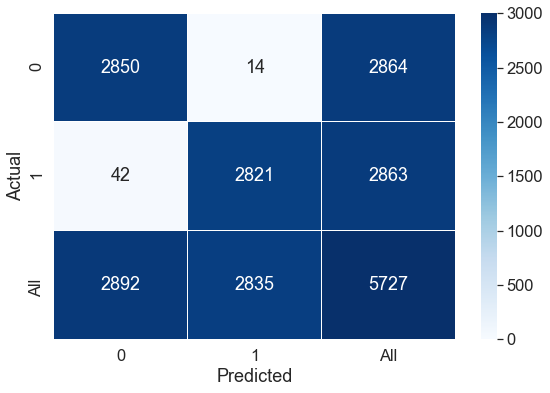

In [26]:
#Confusion Matrix

sns.set(font_scale=1.5)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(confusion_matrix, annot=True , vmin = 0, vmax = 3000, cmap='Blues', fmt='g',  linewidths=0.2, annot_kws={"fontsize":18})
plt.savefig('ConfusionMatix.png')
plt.show()

<Figure size 432x288 with 0 Axes>

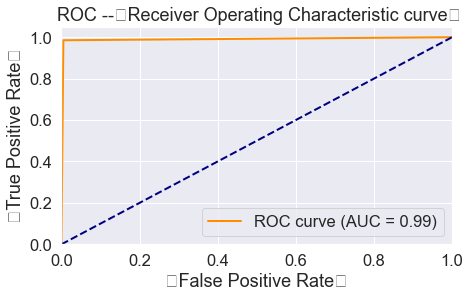

In [27]:
#Roc Curve

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
lw = 2
plt.figure()
f, ax = plt.subplots(figsize=(7, 4))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('（False Positive Rate）')
plt.ylabel('（True Positive Rate）')
plt.title(' ROC --（Receiver Operating Characteristic curve）')
plt.legend(loc="lower right")
plt.savefig('roc_auc.png')
plt.show()

In [28]:
print(f"TPR is {tpr[1]}")

TPR is 0.9853300733496333


In [29]:
print(f"FPR is {fpr[1]}")

FPR is 0.004888268156424581
